In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# Theme 2: Simulation Studies.
The aim of this section is to compare different classification algorithms that have not seen before and do some simulation studies, that is how these methods perform under different sample sizes.

In order to do it we begin presenting what was our first and most simple idea: train and test each algorithm and plot accuracy as a function of sample size. Finally, we try to be more creative and include some "different" ideas.



## 0. Review of the ML Algorithms we will use
(KNN, SVM, QDA, Logistic Regression,Gradient Boosting, Random Forest, Neural Network)

When working with Supervised Learning,different algorithms have different foundations and therefore, in order to understand their similarities and differences we decided to begin setting a clear and organized taxonomy that would allow us to classify each of the algorithms. As we are focusing on Suprevised Learning for classification we followed the taxonomy of "Algorithms Grouped by Similarity" in  https://machinelearningmastery.com/a-tour-of-machine-learning-algorithms/

According to that taxonomy, we can refer to:
- Instance-based (KNN, SVM)
- Bayestian Algorithms (LDA,QDA)
- Regression Algorithms (Logistic Regression)
- Decision Tree Algorithms
- Regularization
- Ensemble (RF)
- Deep Learning (NN)

Other types that we do not use here:
- Clustering
- Association Rule
- Dimensionality Reduction
- Others

### Knn (data-based)


The only assumption is that the closer 2 points the more similar they are. However the notion of distance breaks down in high dimensioanl spaces, that is why PCA can be very useful. I will be using the default distance metric implemented in python: Euclidean distance.

Also, note that we chose to cross-validate with 10 folds because it is a standard number, and the GridSearchCV score (which is the score used to select the best parameters) will be the balanced accuracy, a type of accuracy that performs better in unblanced datasets like our dataset

### SVM

In SVM we assume that the dataset is linearly separable and we want to compute the decision boundary that maximizes the margin. This leads to a Dual-Primal problem that has well-defined solution. When the classes overlap a slack variable is introduced to soften the constraints. Moreover, introducing the kernel trick the model can be generalized to more than linear separations and include some regularization. In our case we will use the Radial Basis Kernel.

###Discriminant Analysis

Finally, we use QDA (the more flexible discriminant analysis) to model p(x,i) assuming that p(x|i) is normal and estimating the prior p(i) from the data.

Assumptions:
- p(x|i) ~ Normal
- QDA assumes that each class has its own covariance matrix

We also compare it with LDA, which assumes the same covariance structure among classes.

### Logistic Regression

Uses the similarity of the logistic function with the standard normal CDF to classify the data after applying a linear transformation to it. If its greater than 0.5 it will be to class 1, lower it will belong to the otehr class. This is, a model approximation for p(i|x). The original model is for binary classification but it can be extended to multi class.

Assumptions:
- Binary classification
- No multicollinearity
- Large sample
- Linear relationship of variables to log odds
- No outliers
- Independent oservations

### Ensemlbles methods: Gradient Boosting and Random Forests


-Boosting: Weak learners are trained sequentially in a way that each learner tries to fix the errors of the previous one and at the end a strong learner combines the weak learners to make a final predcition. There are 5 types of Boosting algortihms:
- **Gradient Tree Boosting**: it uses trees as weak learners using gradient descent.
- AdaBoost: fits weak learners sequentially, giving more weight to correct predictions annd less weight to correct predictions and the final predicitons are obtained by majority.
-XGBoost: it is a regularized version of Gradient Tree Boostin, which tends to be faster and more accurate
- CatBoost: Is specially effective in categorical datasets which creates symmetric decision trees.
- Light GBM: It creates trees in away that only one leaf is grown form each tree.It also works well on categorical datasets.


-Bagging, which stands for Bootstrap Aggregating, is an ensemble learning technique used to improve the stability and accuracy of machine learning algorithms. It reduces variance and helps to avoid overfitting. Although it is often used in conjunction with decision trees, it can be applied to many types of machine learning algorithms for classification and regression tasks.

Here’s how bagging works:

1. Multiple Subsets: Bagging involves creating multiple subsets of the original training dataset, with replacement (bootstrap samples). Each subset is used to train a separate instance of the base model. This means that the same sample can appear more than once in the same subset or in different subsets.

2. Parallel Training: Each subset is used to train a model independently and in parallel with others. This means that bagging can efficiently utilize multicore processors by training different models on different cores.

3. Aggregation of Outputs: For classification tasks (like in your example with **RandomForestClassifier**), the outputs of individual models are combined through a majority voting mechanism. For regression tasks, the final output is typically the average of all the individual predictions.


## 1. Accuracy as a function of the sample size


### 1.1 Plot of accuracy - 10 iterations

We begin implementing 5 models: KNN, QDA, SVM, Lasso and NN. We do it for different sample sizes (10, 20, ..., 190) and plot both the accuracy in the trainning and test set. To get a consistent estimation we do make 10 repetitions and plot the accuracy as the mean of this 10repetitions.

In [ ]:
# Load data
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values.flatten()
m = len(catsndogs) # max sample size
s_z = list(range(10, m + 1, 10)) # sample size
iterations = 10

# Our models
X = {
    'kNN': KNeighborsClassifier(3),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM': SVC(kernel='rbf', gamma='scale', C=1.0),
    'Lasso': Lasso(alpha=0.033932217718953266, max_iter=1000),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
}

train_res = {x: [] for x in X }
test_res =  {x: [] for x in X}

# For loop for sample sizes and our models
for size in s_z:
    train_accuracy = {x: [] for x in X}
    test_accuracy = {x: [] for x in X}
    for _ in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(catsndogs, labels, train_size=size, stratify=labels, random_state=None)

        for model, x in X.items():
            if model == 'Lasso':
                y_train = y_train.astype(float)
                y_test = y_test.astype(float)
                x.fit(X_train, y_train)
                y_train_pred = np.round(x.predict(X_train))
                y_test_pred = np.round(x.predict(X_test))
            else:
                x.fit(X_train, y_train)
                y_train_pred = x.predict(X_train)
                y_test_pred = x.predict(X_test)

            trn_ac = accuracy_score(y_train, y_train_pred)
            tst_ac = accuracy_score(y_test, y_test_pred)

            train_accuracy[model].append(trn_ac)
            test_accuracy[model].append(tst_ac)

    for name in X:
        train_res[name].append(np.mean(train_accuracy[name]))
        test_res[name].append(np.mean(test_accuracy[name]))



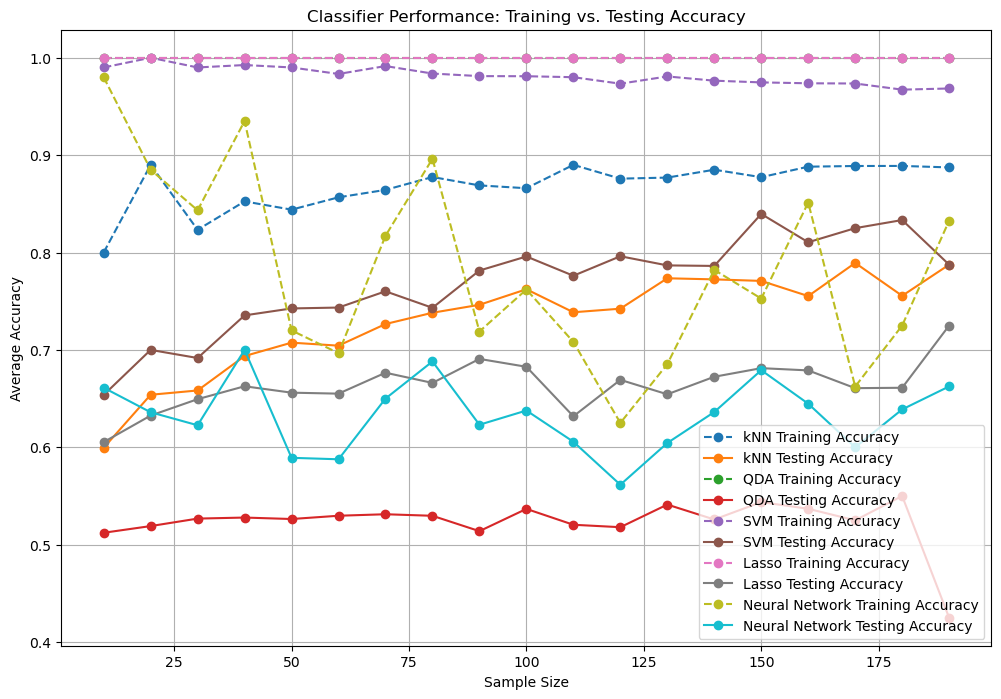

In [ ]:
# Plotting Training vs Testing Performance
plt.figure(figsize=(12, 8))
for x in X:
    plt.plot(s_z, train_res[x], marker='o', linestyle='--', label=f'{x} Training Accuracy')
    plt.plot(s_z, test_res[x], marker='o', label=f'{x} Testing Accuracy')

plt.title('Classifier Performance: Training vs. Testing Accuracy')
plt.xlabel('Sample Size')
plt.ylabel('Average Accuracy')
plt.legend()
plt.grid(True)
plt.show()


This plot includes everything but in order to make it more simple for a potential audience and visual analysis we also created below the plots by trainning and testing accuracy.

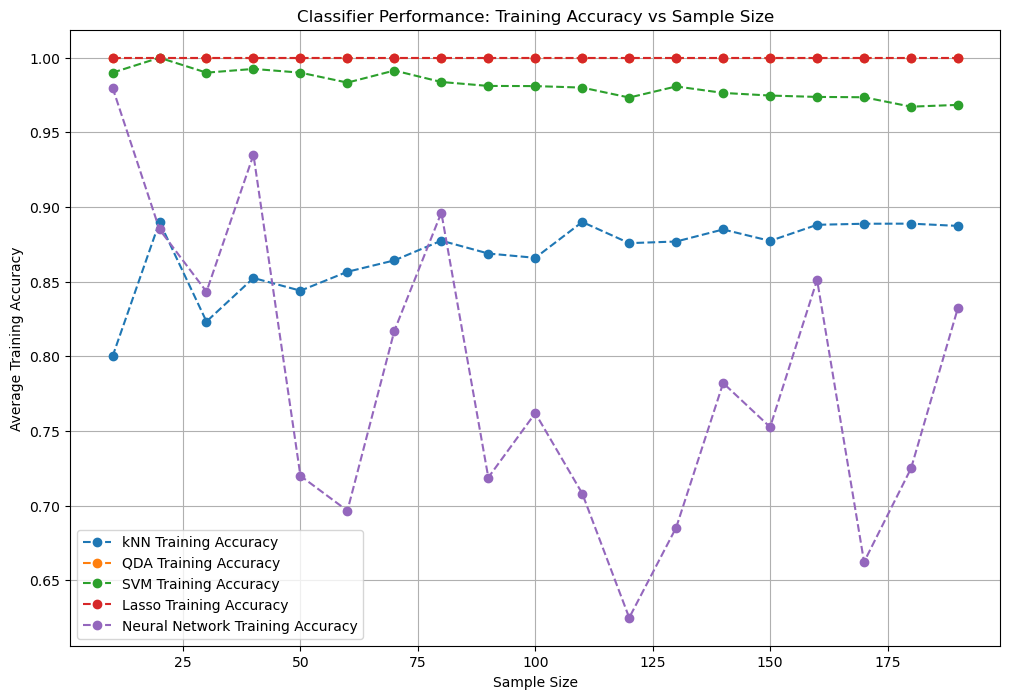

In [ ]:
# Plotting Training Performance
plt.figure(figsize=(12, 8))
for x in X:
    plt.plot(s_z, train_res[x], marker='o', linestyle='--', label=f'{x} Training Accuracy')

plt.title('Classifier Performance: Training Accuracy vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Average Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Training Accuracy:**
- **KNN** produces slowly increasing results with the training set
- **QDA** does not even appear in the plot because is giving around 0.5 accuracy which means that is basically guessing.
- **Kernel SVM** accuracy is high and constant with respect to sample size. This could be due to a "perfect" model or to overfitting.
- **Lasso** trains what it seems an overfitting model as the accuracy is always 1. This could be because the alpha chosen is to low and we would need to apply more regularization.
- **Neural Networks** seem to behave independently of the sample size. Which may indicate that we will get similar results when testing.


Now let's see how these algorithms performed in the unseen data.

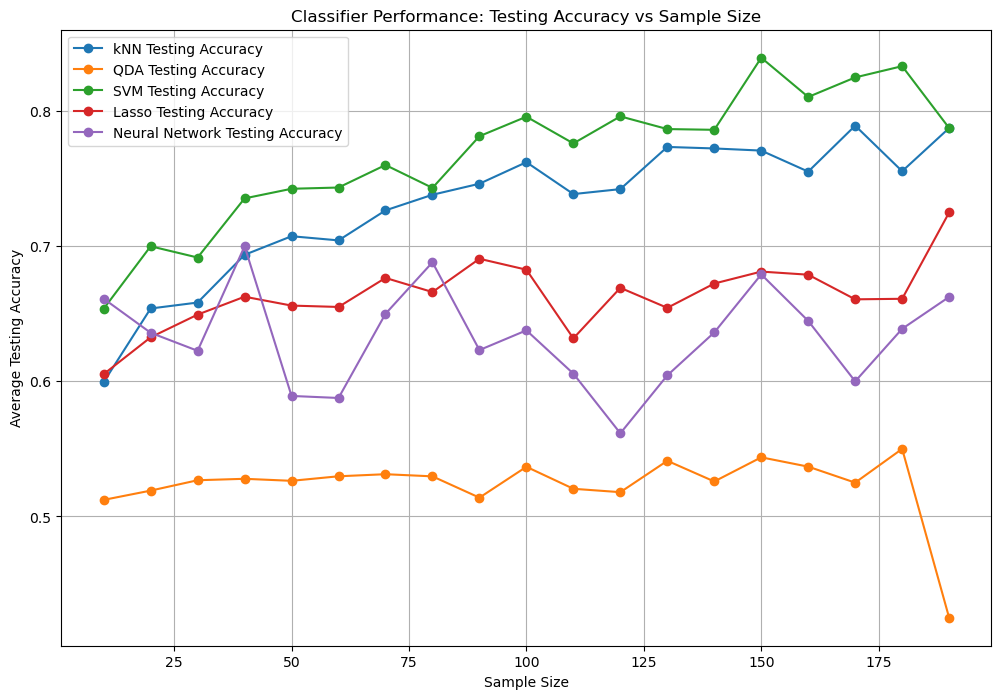

In [ ]:
# Plotting Testing Performance
plt.figure(figsize=(12, 8))
for x in X:
    plt.plot(s_z, test_res[x], marker='o', label=f'{x} Testing Accuracy')

plt.title('Classifier Performance: Testing Accuracy vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Average Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Testing Accuracy:**
First of all, when testing we can see that overall there is a direct relation between the accuracy and the sample size -> the bigger sample size the better results, specially for the models that work good.
- **KNN & Kernel SVM** are the best models for this problem, with and accuracy of around 80% with the biggest sample size. SVM consistenly produce slightly better results.
- **QDA**: as commented before, this model works really bad. It might be due to the model-based assumptions, that intuitively won't hold in the shape of cats/dongs.
- **Lasso**: although it seemed overfitting, it does not produce bad results and is consistent across the sample size.
- **Neural Networks** accuracy is bad and not consistent compared to the other models.

Overall: the models that fit the data more are KNN and SVM. Implicitly this means that the assumptions that hold best for this type of data are 1) Cats and dogs can be differentiated through data-based similarity and 2) Assuming a radial separating kernel is a good option.

### Plot of Accuracy - 100 Iterations

### Confussion matrices for 10 iterations

## 2. More original methods

In this section we came up with different approaches to study the algorithms in as a function of the sample size or less information available as input.

### 2.1 Divide the images into patches.

In the first case, we reduce the information avaiable to train by dividing the image into patches.

1.   Each 64x64 image is divided into smaller non overlapping patches. The images are divided into 4x4 patches each of size 16x16 pixels.

2.   Various classifiers are used to evaluate the patches: K-Nearest Neighbors (KNN), Support Vector Machine (SVM), Gradient Boosting (GB), Quadratic Discriminant Analysis (QDA), Logistic Regression (LR), Neural Network (NN), and Random Forest (RF). The accuracy of each classifier on each patch is calculated. This involves flattening each patch into a vector, splitting the data into training and testing sets, and then training and testing each classifier.

3. The classification process is repeated multiple times (e.g., 10 iterations) to ensure the results are reliable and to average the accuracies.





1. Divide into patches

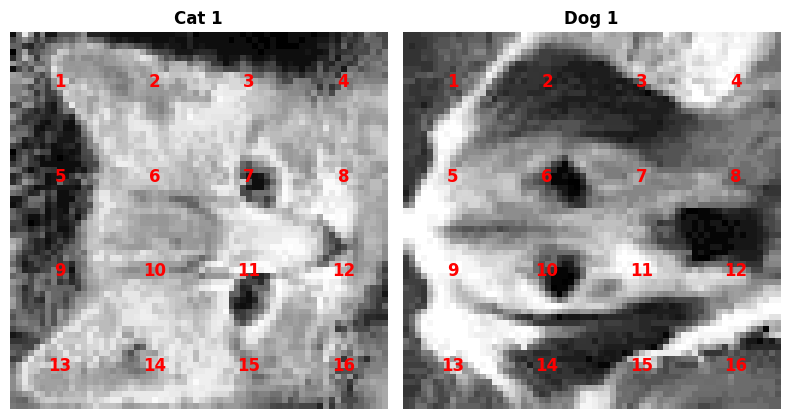

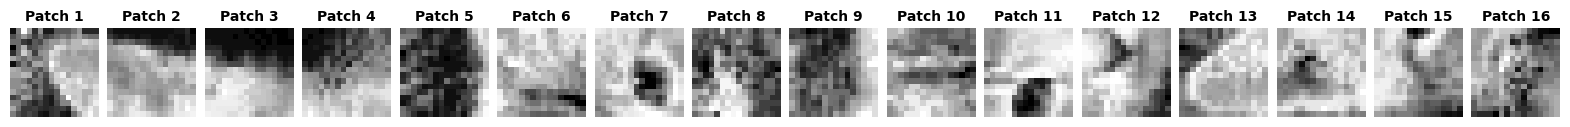

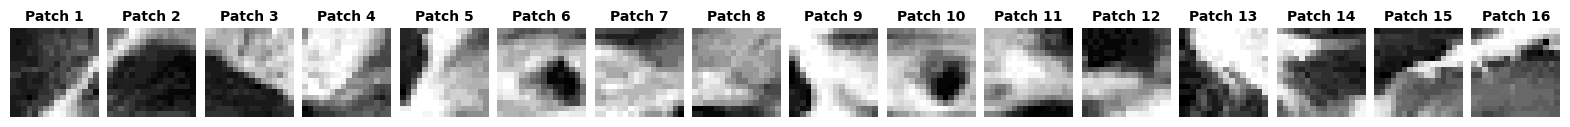

In [ ]:
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values

def rotate_matrix1(x):
    return x#np.flip(x.T, axis=0)
catsndogs = catsndogs.reshape(-1, 64, 64)

total_num_patches = 4
patch_size = int(64 / total_num_patches)  # 16

# Function to create patches
def create_patches(data, patch_size):
    patches = []
    for img in data:
        img_patches = []
        for i in range(0, img.shape[0], patch_size):
            for j in range(0, img.shape[1], patch_size):
                # img_patches.append(img[i:i+patch_size, j:j+patch_size])
                img_patches.append(img[i:i+patch_size, j:j+patch_size])
        patches.append(np.array(img_patches))
    return np.array(patches)

patched_data = create_patches(catsndogs, patch_size)

# Labels for the data (assuming binary classification with 0 for cats and 1 for dogs)
# Visualizing original images
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Indices of the sample images to visualize
sample_indices = [0, 1, 2, 3]
sample_indices = [0, 2]

# Titles for the subplots
# titles = ["Cat 1", "Cat 2", "Dog 1", "Dog 2"]
titles = ["Cat 1","Dog 1"]


def mark_patches(ax, img, patch_size, total_num_patches):
    for i in range(total_num_patches):
        for j in range(total_num_patches):
            x = j * patch_size
            y = i * patch_size
            patch_num = i * total_num_patches + j + 1
            ax.text(x + patch_size//2, y + patch_size//2, str(patch_num),
                    color='red', fontsize=12, ha='center', va='center', fontweight='bold')

# Visualizing original images
for i, idx in enumerate(sample_indices):
    ax = axs[i]
    img = rotate_matrix1(catsndogs[idx])
    ax.imshow(img, cmap='gray')
    mark_patches(ax, img, patch_size, total_num_patches)

    ax.axis('off')
    ax.set_title(titles[i], fontweight='bold', fontsize=12)

# fig.suptitle('Original Data', fontsize=14, fontweight='bold', verticalalignment='top', y=0.8)
plt.tight_layout()
plt.show()

# Visualizing all patches for each selected image
for i, idx in enumerate(sample_indices):
    patches = patched_data[idx]
    num_patches = patches.shape[0]

    fig, axs = plt.subplots(1, num_patches, figsize=(20, 5), dpi=100)
    # fig.suptitle(f'Patches of {titles[i]}', fontsize=14, fontweight='bold', verticalalignment='top', y=1.05)

    for j in range(num_patches):
        patch = patches[j]
        axs[j].imshow(rotate_matrix1(patch), cmap='gray')
        axs[j].axis('off')
        axs[j].set_title(f'Patch {j+1}', fontweight='bold', fontsize=10)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [ ]:
from sklearn.ensemble import BaggingClassifier

def perform_grid_search(X, y):
    parameter_grids = {
        'KNN': {
            'n_neighbors': [3, 5, 7]
        },
        'SVM': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10]
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        },
        'QDA': {
            # QDA has no hyperparameters to tune
        },
        'Logistic Regression': {
            'C': [0.01, 0.1, 1, 10],
            'max_iter': [100, 500, 1000]
        },
        'Neural Network': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'max_iter': [500, 1000]
        },
        # 'Random Forest': {
        #     'n_estimators': [50, 100, 200]
        # },
        'Lasso': {
            #'alpha': [0.01, 0.1, 1, 10]
        },
        'Bagging RandomForest': {
            'n_estimators': [10, 50, 100],
            'estimator__n_estimators': [50, 100, 200],
            'estimator__max_features': [0.5, 1.0]
        }
    }

    best_params = {}
    classifiers = {
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'QDA': QuadraticDiscriminantAnalysis(),
        'Logistic Regression': LogisticRegression(),
        'Neural Network': MLPClassifier(),
        # 'Random Forest': RandomForestClassifier(),
        'Lasso': LassoCV(n_jobs=-1),
        'Bagging RandomForest': BaggingClassifier(estimator=RandomForestClassifier(), random_state=0)
    }

    for name, clf in classifiers.items():
        if name in parameter_grids:
            grid_search = GridSearchCV(clf, parameter_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X, y)
            best_params[name] = grid_search.best_params_
        else:
            best_params[name] = {}

    return best_params

sample_data = patched_data[:, 0]
best_params = perform_grid_search(sample_data, labels)



In [ ]:
joblib.dump(best_params, f"best_paramteres.joblib")
print(f"Best parameters saved: best_parameters.joblib")

best_params = joblib.load(f"best_paramteres.joblib")
print(best_params)

Best parameters saved: best_parameters.joblib
{'KNN': {'n_neighbors': 3}, 'SVM': {'C': 1, 'kernel': 'rbf'}, 'Gradient Boosting': {'learning_rate': 0.2, 'n_estimators': 50}, 'QDA': {}, 'Logistic Regression': {'C': 0.1, 'max_iter': 500}, 'Neural Network': {'hidden_layer_sizes': (100,), 'max_iter': 1000}, 'Lasso': {}, 'Bagging RandomForest': {'estimator__max_features': 0.5, 'estimator__n_estimators': 50, 'n_estimators': 100}}


2,3. Training and getting accuracy of the classifiers averaging across 10 iterations.

In [ ]:
import joblib
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neural_network import MLPClassifier

def evaluate_classifiers_with_best_params(patched_data, labels, best_params, iterations=10):
    num_patches = patched_data.shape[1]
    classifiers = {
        'KNN': KNeighborsClassifier(**best_params['KNN'], n_jobs=-1),
        'SVM': SVC(**best_params['SVM']),
        'Gradient Boosting': GradientBoostingClassifier(**best_params['Gradient Boosting']),
        'QDA': QuadraticDiscriminantAnalysis(**best_params['QDA']),
        'Logistic Regression': LogisticRegression(max_iter=10000, **{k: v for k, v in best_params['Logistic Regression'].items() if k != 'max_iter'}),
        'Neural Network': MLPClassifier(**best_params['Neural Network']),
        # 'Random Forest': RandomForestClassifier(**best_params['Random Forest'], n_jobs=-1),
        'Lasso': LassoCV(n_jobs=-1, max_iter=10000),  # Use LassoCV with all CPUs and increased max_iter
        'Bagging RandomForest': BaggingClassifier(
            estimator=RandomForestClassifier(
                n_estimators=best_params['Bagging RandomForest']['estimator__n_estimators'],
                max_features=best_params['Bagging RandomForest']['estimator__max_features'],
                n_jobs=-1
            ),
            n_estimators=best_params['Bagging RandomForest']['n_estimators'],
            n_jobs=-1,
            random_state=0
        )
    }

    accuracies = {name: np.zeros(num_patches) for name in classifiers.keys()}

    for _ in range(iterations):
        iteration_accuracies = {name: [] for name in classifiers.keys()}

        for patch_idx in range(num_patches):
            patch_data = patched_data[:, patch_idx]

            X_train, X_test, y_train, y_test = train_test_split(patch_data, labels, test_size=0.3, stratify=labels)

            for name, clf in classifiers.items():
                clf.fit(X_train, y_train)
                preds = clf.predict(X_test)
                if name =='Lasso':
                    preds  = np.where(preds >= 0.5, 1, 0)
                acc = accuracy_score(y_test, preds)
                iteration_accuracies[name].append(acc)

        for name in classifiers.keys():
            accuracies[name] += np.array(iteration_accuracies[name])

    for name in classifiers.keys():
        accuracies[name] /= iterations

    return accuracies

mean_accuracies = evaluate_classifiers_with_best_params(patched_data, labels, best_params, iterations=10)


(10, 16)
(16,)


Plot the accuracies

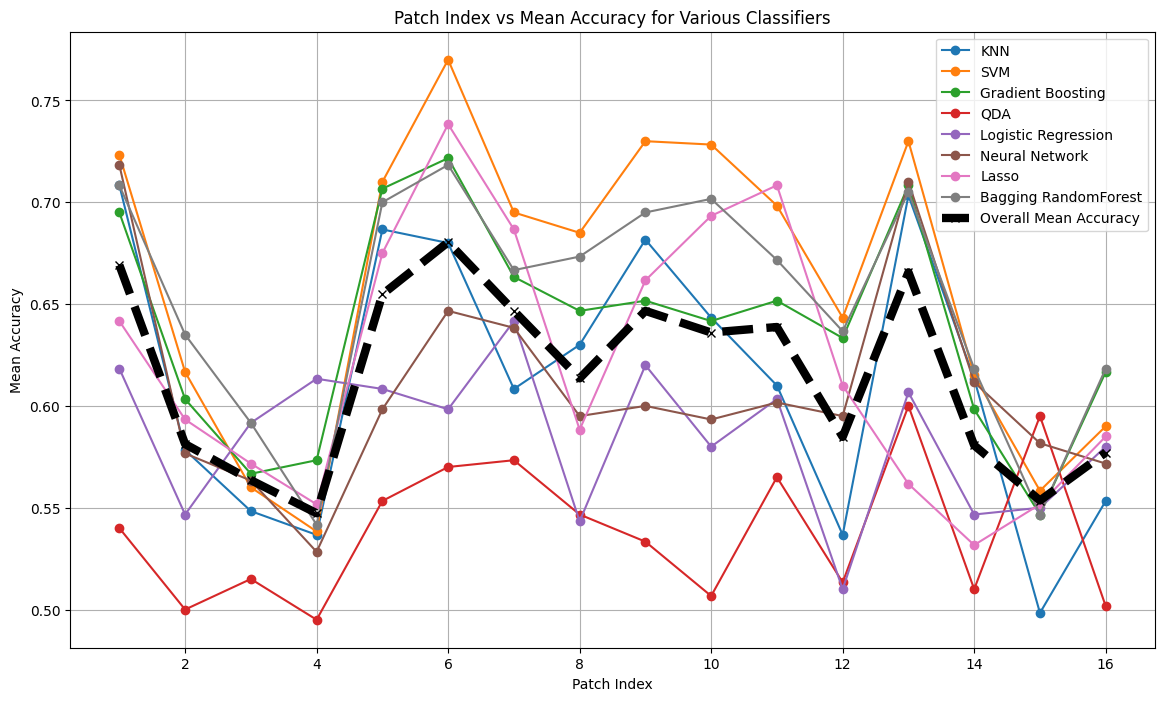

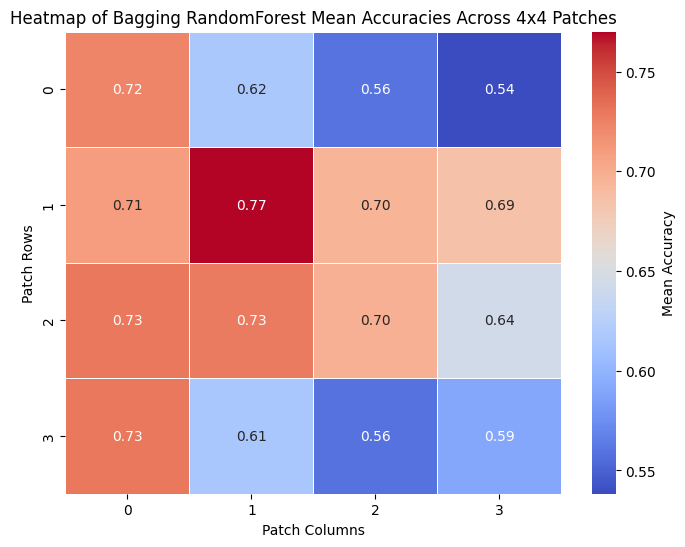

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

all_accuracies = np.array(list(mean_accuracies.values()))
overall_mean_accuracy = np.mean(all_accuracies, axis=0)

patch_indices = np.arange(1, all_accuracies.shape[1] + 1)

plt.figure(figsize=(14, 8))

for name, acc in mean_accuracies.items():
    plt.plot(patch_indices, acc, label=name, marker='o')

plt.plot(patch_indices, overall_mean_accuracy, label='Overall Mean Accuracy', marker='x', linestyle='--', color='black', linewidth=6 )

plt.xlabel('Patch Index')
plt.ylabel('Mean Accuracy')
plt.title('Patch Index vs Mean Accuracy for Various Classifiers')
plt.legend()
plt.grid(True)
plt.show()

rf_accuracies = mean_accuracies['SVM']
rf_accuracies = np.array(rf_accuracies)


patch_grid_size = 4
accuracy_grid = rf_accuracies.reshape(patch_grid_size, patch_grid_size)

plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_grid, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Mean Accuracy'})
plt.title('Heatmap of Bagging RandomForest Mean Accuracies Across 4x4 Patches')
plt.xlabel('Patch Columns')
plt.ylabel('Patch Rows')
plt.show()


The models that work better ... **agree first in which models to use**

Overall, there is some consistency across models about the patches that perform worse and better. When one focuses on patches 3,4,8,12,14,15,16 the accuracy tends to substantially decrease below 60%. When seeing which parts of the image belong to these patches we find a consistent and reasonable explanation: the predictive capacity is NOT in the lower part of the images. Converserly, the patches with better accuracy are 1,5,6,7,9,10,11,13 which correspond to the upper part of the image. In summary, all models agree that the most of the predictive information of catsndogs lies on the intrinsic features on the upper part of their heads.

The best performed is SVM with RBF kernel and worst perfomerd is QDA and Logistic regression.

In the following code, PCA is perfomed and decision boundary in SVM, QDA and logistc regression are visualized.

In [ ]:
clf = RandomForestClassifier(**best_params['Random Forest'])
X_train, X_test, y_train, y_test = train_test_split(patched_data[:, 5], labels, test_size=0.3, stratify=labels)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


incorrect_indices = np.where(y_test != y_pred)[0]
print("Indices of incorrectly classified images:", incorrect_indices)


Indices of incorrectly classified images: [ 0  9 14 26 29 31 45 47 48 51 52 56]


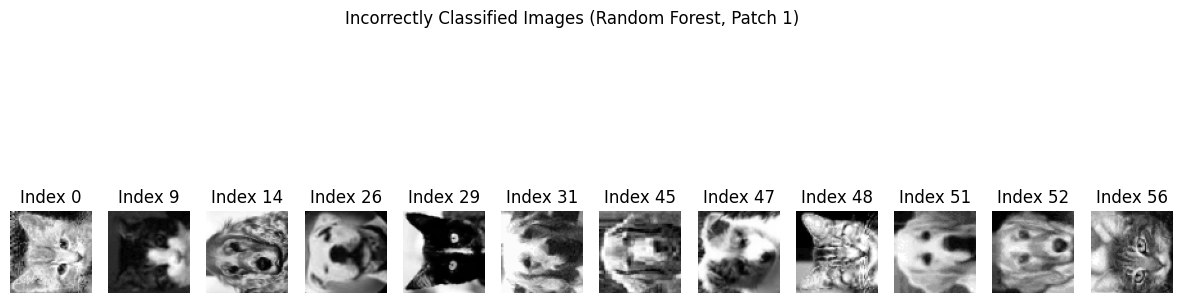

In [ ]:
import matplotlib.pyplot as plt

def visualize_incorrect_images(data, indices, title):
    num_images = len(indices)
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = data[idx].reshape(64, 64)
        plt.imshow(img, cmap='gray')
        plt.title(f"Index {idx}")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

visualize_incorrect_images(catsndogs, incorrect_indices, "Incorrectly Classified Images (Random Forest, Patch 1)")


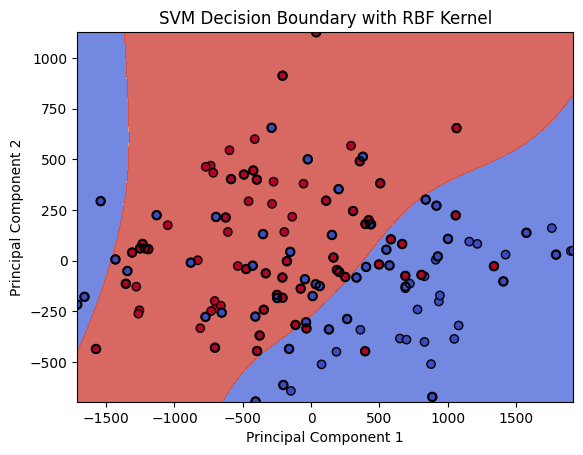

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

patch_data = patched_data[:, 5]

X_train, X_test, y_train, y_test = train_test_split(patch_data, labels, test_size=0.3, stratify=labels)

svm_rbf = SVC(kernel='rbf', C=best_params_svm['C'], gamma='scale')
svm_rbf.fit(X_train, y_train)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

svm_rbf_pca = SVC(kernel='rbf', C=best_params_svm['C'], gamma='scale')
svm_rbf_pca.fit(X_train_pca, y_train)

h = 0.5
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


Z = svm_rbf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.scatter(svm_rbf_pca.support_vectors_[:, 0], svm_rbf_pca.support_vectors_[:, 1], facecolors='none', edgecolors='k', linewidths=1.5)
plt.title('SVM Decision Boundary with RBF Kernel')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


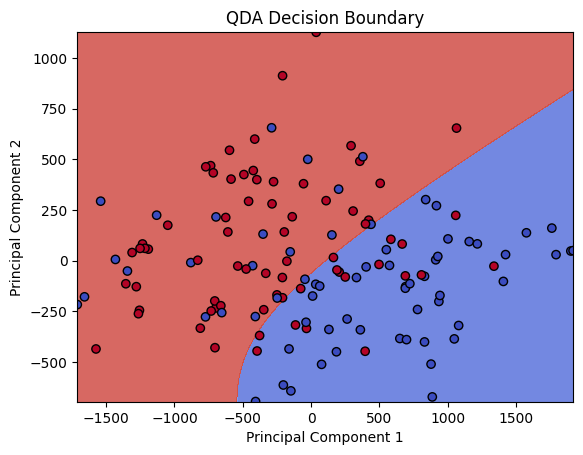

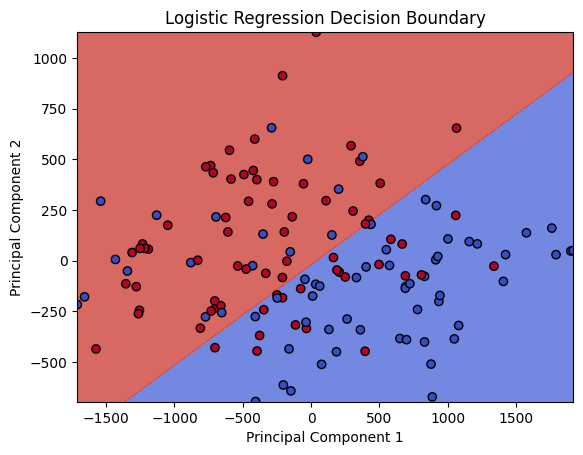

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

qda_pca = QuadraticDiscriminantAnalysis()
qda_pca.fit(X_train_pca, y_train)

h = 0.5
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = qda_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title('QDA Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

lr_pca = LogisticRegression(max_iter=1000)
lr_pca.fit(X_train_pca, y_train)

Z = lr_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title('Logistic Regression Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


### 2.2 Increase the proportion of dogs.

In this last case we decided to see how this algorithms perform as the dataset becomes more unbalanced. Intuitively, it makes sense that as the proportion of dogs increases the algorithms tend to classify everything as a dog, especially the data-based ones. To implement it we decided to slowly increase the % of dogs by removing cats of the sample size until in the limit there are only dogs. In this case, as a measure metric we used the proportion of cats classified as dogs -> will show a tendecy to overclassify as dogs if that is the case.

In [ ]:
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values

indices_dogs = np.where((labels == 1))[0]
indices_cats = np.where((labels == 0))[0]
labels_dogs=labels[indices_dogs]
labels_cats=labels[indices_cats]
features_dogs=catsndogs[indices_dogs]
features_cats=catsndogs[indices_cats]

def unbalance_data(proportion_dogs):
    cats_to_remove=int((198*proportion_dogs - 101)/proportion_dogs)
    random_indices = np.random.choice(len(indices_cats), size=cats_to_remove, replace=False)
    new_labels_cats= np.delete(labels_cats, random_indices).reshape(-1, 1)
    new_features_cats= np.delete(features_cats, random_indices,axis=0)

    X=np.vstack((features_dogs,new_features_cats))
    y=np.vstack((labels_dogs,new_labels_cats))
    return X,y

def calculate_false_dogs(y_true, y_pred):
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Extract the number of classes
    num_classes = conf_matrix.shape[0]

    # Initialize false negatives array
    false_positives = np.zeros(num_classes)

    # Calculate false negatives for each class
    for i in range(num_classes):
        false_positives[i] = conf_matrix[:, i].sum() - conf_matrix[i, i]

    return false_positives[1]/(np.size(y_true)-sum(y_true))

def average_dicts(dicts):
    if not dicts:
        return {}

    # Initialize the result dictionary with zeros
    result = {key: 0 for key in dicts[0]}
    num_dicts = len(dicts)

    # Sum the values of corresponding keys
    for d in dicts:
        for key in d:
            result[key] += d[key]

    # Divide by the number of dictionaries to get the average
    for key in result:
        result[key] /= num_dicts

    return result

# Assuming 'catsndogs' and 'labels' are your data and labels loaded appropriately
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values

# Set the full range of sample sizes from 10 up to the size of the full dataset, incrementing by 10
over_sampling=[0.55,0.7,0.8,0.9]

# Define models
models = {
    'kNN': KNeighborsClassifier(3),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM': SVC(kernel='rbf', gamma='scale', C=1),
    "LR":LogisticRegression(max_iter=1000),
    "NN": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
    "rf": RandomForestClassifier(n_estimators=100)

}

results = {model: [] for model in models}

# Experiment across sample sizes
for i in range(10):
  for size in over_sampling:
    X,y=unbalance_data(size)
    #X,y=catsndogs, labels
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.25, random_state=42)  # 25% for testing

    for name, model in models.items():
      model.fit(X_train, y_train)  # Train model
      y_pred = model.predict(X_test)  # Predict on test set
      accuracy = calculate_false_dogs(y_test, y_pred.round())  # Calculate accuracy
      results[name].append(accuracy)

results=average_dicts()

# Plot results
plt.figure(figsize=(12, 8))
for model, accuracies in results.items():
  plt.plot(over_sampling, accuracies, marker='o', label=f'{model}')

plt.title('% of Total Cats Classified as Dogs')
plt.xlabel('% of Dogs in Sample Size')
plt.ylabel('Error %')
plt.legend()
plt.grid(True)
plt.show()

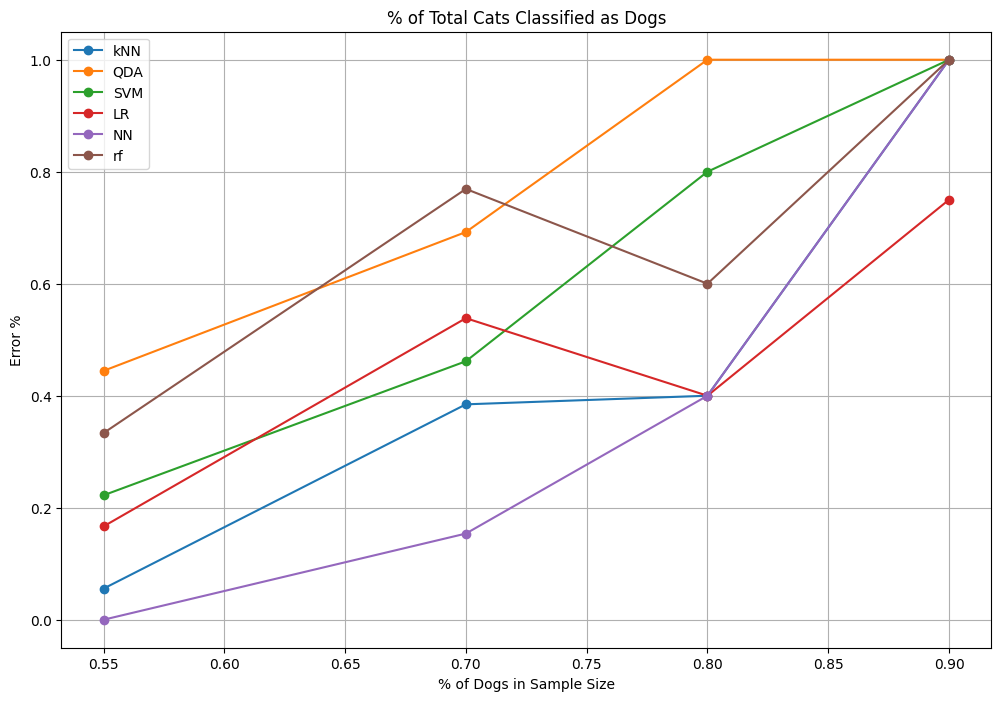

In [ ]:
# Plot results
plt.figure(figsize=(12, 8))
for model, accuracies in results.items():
  plt.plot(over_sampling, accuracies, marker='o', label=f'{model}')

plt.title('% of Total Cats Classified as Dogs')
plt.xlabel('% of Dogs in Sample Size')
plt.ylabel('Error %')
plt.legend()
plt.grid(True)
plt.show()

To conclude, after taking the mean across 5 iterations its obvious that there is a direct relation regardless of the algorithm you use, showing that ML algorithms work impressively when the situation hold, but it is unlikely that they would ever tell you "out of the rule" events.